# Exercise on the value of unsupervised constructed features for training a classifier with few labeled examples: SOLUTION

To get unsupervised constructed features of an image, we can use a pretrained CNN as feature extractor.

We have done this to extract features from 100 Cifar10 images.  As pretrained CNN we use a VGG16 architecture that was trained on ImageNet data and was the second winner of the ImageNet competition in 2014.

As a check on the quality of the feature representation of the CIFAR10 data, we will use once the pixel-features and once the VGG-features to train a classifier using this 100 labeled data (on average 10 per class). If the VGG-feature are indeed better than the raw pixel values, we would expect to achieve a better classifier when using the VGG-feature compared to the pixel feature.

a) Which accuracy would you expect for a classifier which cannot distinguish between the 10 classes and is only guessing?

**Solution: 10%**


b) Go through the code which is used to set-up, train, and evaluate a CNN classifier using the raw pixel features. Discuss your thoughts on the achieved accuracy (e.g. with your neighbor).

**Solution: The accuracy is with around 20% better then guessing but still very bad. However, this is not surprising since the resolution of the images are very low and it is alread by eye quite difficult to distinguish between the classes. Moreover, we have  only very few training examples (only 10 per class), quite bad features (the raw pixel values) and a model with many parameters (around 45k parameter).**

b) Now we use the unsupervised constructed VGG features. We want to check, if these VGG features are good enough to train a classifier with only few labeled data and still get a satisfying performance. For this purpose, please complete the code to set up a fully connected NN and run the provided subsequent code to train it and determine its accuracy on the test set. Compare it to the accuracy which we achieve with a RF. Discuss the results (e.g. with your neighbor).

**Solution: For code completion see below. The accuracy of the fcNN is with more than 55% much better than the accuray of the from scratch trained CNN which was 20%. This implies that the VGG-features are quite good and more informative than the raw pixel features. With the RF we achieve a similar performance.**



## Imports

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pylab import *

import time
import tensorflow as tf

import  tensorflow.keras as keras
import sys

## CIFAR Data preparation

In [ ]:
#downlad cifar data
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
del [x_test,y_test]

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
#loop over each class label and sample 100 random images over each label and save the idx to subset
np.random.seed(seed=222)
idx=np.empty(0,dtype="int8")
for i in range(0,len(np.unique(y_train))):
    idx=np.append(idx,np.random.choice(np.where((y_train[0:len(y_train)])==i)[0],100,replace=False))

x_train= x_train[idx]
y_train= y_train[idx]

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(np.unique(y_train,return_counts=True))

(1000, 32, 32, 3)
(1000, 1)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]))


In [ ]:
#make train valid and test
#loop over each class label and sample 100 random images over each label and save the idx to subset
np.random.seed(seed=123)
idx_train=np.empty(0,dtype="int8")
for i in range(0,len(np.unique(y_train))):
    idx_train=np.append(idx_train,np.random.choice(np.where((y_train[0:len(y_train)])==i)[0],10,replace=False))

x_train_new = x_train[idx_train]
y_train_new = y_train[idx_train]

In [ ]:
x_test_new=(np.delete(x_train,idx_train,axis=0))
y_test_new=(np.delete(y_train,idx_train,axis=0))

In [ ]:
np.random.seed(seed=127)
idx_valid=np.empty(0,dtype="int8")
for i in range(0,len(np.unique(y_test_new))):
    idx_valid=np.append(idx_valid,np.random.choice(np.where((y_test_new[0:len(y_test_new)])==i)[0],10,replace=False))

x_valid_new = x_test_new[idx_valid]
y_valid_new = y_test_new[idx_valid]

In [ ]:
x_test_new=(np.delete(x_test_new,idx_valid,axis=0))
y_test_new=(np.delete(y_test_new,idx_valid,axis=0))

In [ ]:
x_train_new = np.reshape(x_train_new, (100,32,32,3))
x_valid_new = np.reshape(x_valid_new, (100,32,32,3))
x_test_new = np.reshape(x_test_new, (800,32,32,3))

In [ ]:
print(np.unique(y_train_new,return_counts=True))
print(np.unique(y_valid_new,return_counts=True))
print(np.unique(y_test_new,return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([80, 80, 80, 80, 80, 80, 80, 80, 80, 80]))


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_new=to_categorical(y_train_new,10)
y_valid_new=to_categorical(y_valid_new,10)
y_test_new=to_categorical(y_test_new,10)



In [ ]:
print(x_train_new.shape)
print(y_train_new.shape)

print(x_valid_new.shape)
print(y_valid_new.shape)

print(x_test_new.shape)
print(y_test_new.shape)

(100, 32, 32, 3)
(100, 10)
(100, 32, 32, 3)
(100, 10)
(800, 32, 32, 3)
(800, 10)


In [ ]:
# center and standardize the data
X_mean = np.mean( x_train_new, axis = 0)
X_std = np.std( x_train_new, axis = 0)

x_train_new = (x_train_new - X_mean ) / (X_std + 0.0001) # Normalisierung, bzw. insbesonder Z-Tranformation, ganz kleine Zahl dazu damit nicht durch Null teilen
x_valid_new = (x_valid_new - X_mean ) / (X_std + 0.0001)
x_test_new = (x_test_new - X_mean ) / (X_std + 0.0001)

## Baseline 1: use raw images to train a Random Forest model

In [ ]:
# reshape images for rf
x_train_rf = x_train_new.reshape(len(x_train_new),32*32*3)
x_valid_rf = x_valid_new.reshape(len(x_valid_new),32*32*3)
x_test_rf = x_test_new.reshape(len(x_test_new),32*32*3)
# funktioniert immer deshalb, kaum Overfitting möglich, deshalb sehr beliebt als Baseline
# man muss nicht standardisieren
# ist invariant zum Skalieren
# nimmt Bildstruktur nicht rein...

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(x_train_rf, np.argmax(y_train_new, axis=1)) # one hot encoding rückwärts machen

RandomForestClassifier()

Accuracy =  0.22875


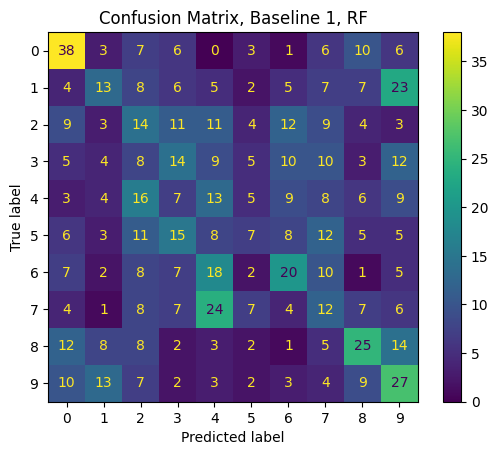

(Text(0.5, 1.0, 'Confusion Matrix, Baseline 1, RF'), None)

In [ ]:
pred=clf.predict(x_test_rf)
# get confusion matrix
cm = confusion_matrix(np.argmax(y_test_new, axis=1), pred)

acc_fc = np.sum(pred == np.argmax(y_test_new, axis=1)) / len(np.argmax(y_test_new, axis=1))
print("Accuracy = " , acc_fc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix, Baseline 1, RF'),plt.show()

# besser als random
# aber nicht toll

## Setting up the the CNN classifier based on raw image data

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten


In [ ]:
# here we define hyperparameter of the NN
batch_size = 10
nb_classes = 10
nb_epoch = 30
img_rows, img_cols = 32, 32
kernel_size = (3, 3)
input_shape = (img_rows, img_cols, 3)
pool_size = (2, 2)

In [ ]:
model = Sequential()

model.add(Convolution2D(8,kernel_size,padding='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(8, kernel_size,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Convolution2D(16, kernel_size,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(16,kernel_size,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(40))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 8)         32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32, 32, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         584       
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 8)         32        
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 32, 32, 8)         0

In [ ]:
history=model.fit(x_train_new, y_train_new,
                  batch_size=10,
                  epochs=30,
                  verbose=0, #2,
                  validation_data=(x_valid_new, y_valid_new),shuffle=True)
# klares Overfitting da konstant im train 0.9 und im valid 0.2 acc

### Evaluation of the CNN classifier that was trained on raw image data

25/25 [==============================] - 1s 28ms/step
Accuracy =  0.2275


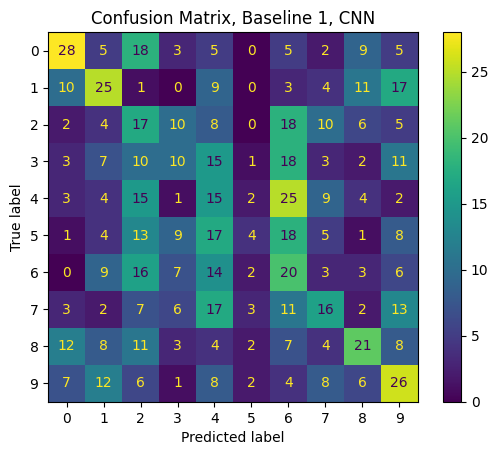

In [ ]:
pred=model.predict(x_test_new)
cm = confusion_matrix(np.argmax(y_test_new,axis=1), np.argmax(pred,axis=1))
acc_fc = np.sum(np.argmax(y_test_new,axis=1)==np.argmax(pred,axis=1))/len(y_test_new)
print("Accuracy = " , acc_fc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix, Baseline 1, CNN')
plt.show();


## Getting the VGG features for CIFAR

In [ ]:
# Downloading embeddings
import urllib
import os
if not os.path.isfile('cifar_EMB_1000.npz'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/si287al91c1ls0d/cifar_EMB_1000.npz?dl=1",
    "cifar_EMB_1000.npz")
%ls -hl cifar_EMB_1000.npz

-rw-r--r-- 1 root root 18M Mar 12 12:40 cifar_EMB_1000.npz


In [ ]:
Data=np.load("cifar_EMB_1000.npz")
vgg_features_cifar = Data["arr_0"]
# ist gecached, wurde auf ganz anderen Daten trainiert
# dort dense layer am Schluss, daraus features für hier, siehe unten für random forest

In [ ]:
vgg_features_cifar_train = vgg_features_cifar[idx_train]
vgg_features_cifar_test=(np.delete(vgg_features_cifar,idx_train,axis=0))
vgg_features_cifar_valid = vgg_features_cifar_test[idx_valid]
vgg_features_cifar_test=(np.delete(vgg_features_cifar_test,idx_valid,axis=0))


In [ ]:
print(vgg_features_cifar_train.shape)
print(vgg_features_cifar_valid.shape)
print(vgg_features_cifar_test.shape)

(100, 4096)
(100, 4096)
(800, 4096)


## Baseline 2: use VGG feature to train a Random Forest model

In [ ]:
clf = RandomForestClassifier()
clf.fit(vgg_features_cifar_train,np.argmax(y_train_new, axis=1))
# random nimmt nun features des anderen Modells anstatt die Pixel

RandomForestClassifier()

Accuracy =  0.5625


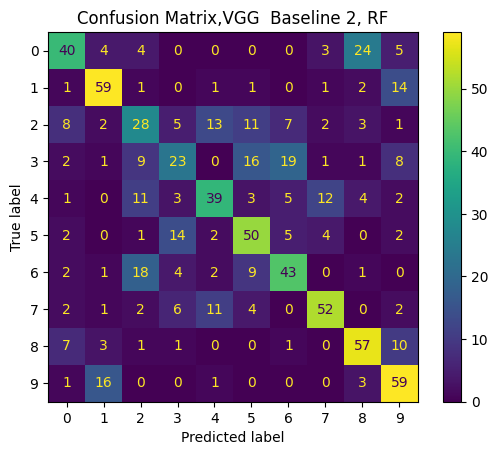

In [ ]:
pred=clf.predict(vgg_features_cifar_test)
# get confusion matrix
cm = confusion_matrix(np.argmax(y_test_new, axis=1), pred)

acc_fc = np.sum(pred==np.argmax(y_test_new, axis=1))/len(np.argmax(y_test_new, axis=1))
print("Accuracy = " , acc_fc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix,VGG  Baseline 2, RF'),plt.show();


## Setting up the the NN classifier based on VGG feature

In [ ]:
model = Sequential()
model.add(Dense(200,batch_input_shape=(None, 4096)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(200))

#### we still need to add the last layers to get the predictions on the 10 classes
### your code here

model.add(Dense(nb_classes))
model.add(Activation('softmax')) # damit 10 Klassen mit Probability herauskommt

####### end of your code ######


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 200)               819400    
                                                                 
 batch_normalization_6 (Bat  (None, 200)               800       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 activation_8 (Activation)   (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 200)               40200     
                                                                 
 dense_7 (Dense)             (None, 10)                2010      
                                                      

In [ ]:
history=model.fit(vgg_features_cifar_train, y_train_new,
                  batch_size=10,
                  epochs=20,
                  verbose=0, #2,
                  validation_data=(vgg_features_cifar_valid, y_valid_new),shuffle=True)

### Evaluation of the NN classifier that was trained on VGG features

25/25 [==============================] - 0s 4ms/step
Accuracy =  0.59125


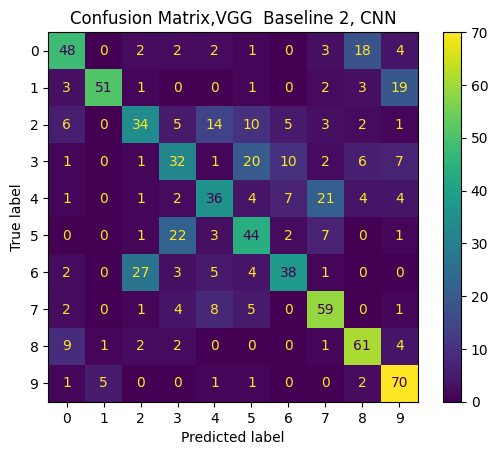

In [ ]:
pred=model.predict(vgg_features_cifar_test)
# get confusion matrix
#### we now want to get the confusion matrix for the predictions on the test data
### your code here
cm = confusion_matrix(np.argmax(y_test_new,axis=1),np.argmax(pred,axis=1))

acc_fc = np.sum(np.argmax(y_test_new,axis=1)==np.argmax(pred,axis=1))/len(y_test_new)
print("Accuracy = " , acc_fc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix,VGG  Baseline 2, CNN'),plt.show();
########## end of your code ###############################

In [ ]:
# wenn man zweidim daten hat, dann bringt CNN etwas
# transfer learning: bereits erstelltes Modell zuerst verwenden und dann nachtrainieren...
# nur NN 23%, mit vortrainiertem CNN plus nachtrainieren gibt 59%

# idee: filter des anderen Modell lernte was allgemeines